<h1>Geospatial Data Analysis of the Tour du Mont Blanc</h1>

# Table of Contents <a id='back'></a>

* [Introduction](#intro)
* [Data parsing](#data_parsing)
* [GPX statistics](#GPX_statistics)
* [Creating a DataFrame](#dataframe)
* [Adding new columns](#new_columns)
* [TMB statistics](#TMB_statistics)
* [TMB visualizations](#TMB_visualizations)
    * [TMB route](#TMB_route)
    * [TMB route per day](#TMB_route_day)
    * [TMB route elevation](#TMB_route_elevation)
    * [Elevation profile](#TMB_elevation_profile)
    * [Elevation profile per day](#TMB_elevation_profile_day)
    * [Elevation profile and distance per day](#TMB_elevation_profile_day_distance)
    * [Lodging and distance per day](#TMB_lodging_distance)
    * [Total distance per country](#distance_country)
    * [Distance per day: flat, uphill, downhill](#distance_profile)
    * [Hiking time per day](#duration_day)
    * [Average speed per day](#speed_day)

<h1>Introduction</h1> <a id='intro'></a>

__Data source:__ \
The dataset consists of 13 GPX files recorded with OsmAnd Maps during the Tour du Mont Blanc (TMB) trek.

__Data structure:__ \
Each raw file contains:
- GPS coordinates (latitude, longitude)
- timestamp
- elevation
- speed

__Data description:__
* Total tracks: 13.
* Each track corresponds to a daily stage of the TMB route.
* Approximate total route distance: ~200 km.
* Each track includes multiple segments due to separate recordings.
* Number of data points per segment varies depending on GPS recording frequency and stage length.

__Purposes:__
* Analyze distance, elevation gain/loss, and overall trekking metrics.
* Visualize the route.
* Perform terrain analysis.
* Explore performance metrics.

<h1>Data parsing</h1> <a id='data_parsing'></a>

In [6]:
# a Python library for parsing and manipulating GPX files
pip install gpxpy

In [7]:
# a Python library for generating static images from interactive Plotly charts (to be displayed in GitHub)
!pip install kaleido==0.2.1

In [8]:
import os
import glob
import gpxpy
import numpy as np
import pandas as pd
from zoneinfo import ZoneInfo
from datetime import time, date
import plotly.express as px
from IPython.display import Image

In [9]:
# path to the folder with GPX files
folder = 'TMB data'

# key: track name or custom name, value: GPX object
parsed_files = {}

# glob.glob() function selects files based on patterns: a pattern is an argument, returns a list of filepaths that match the pattern.
for file in sorted(glob.glob(f"{folder}/*.gpx")):
    # read and parse all GPX files
    try:
        with open(file, "r") as gpx_file:
            gpx = gpxpy.parse(gpx_file)
    except FileNotFoundError:
        print(f"Error: GPX file not found at '{folder}'")
    
    parsed_files[file] = gpx

[Back to Contents](#back)

<h1>GPX statistics</h1> <a id='GPX_statistics'></a>

In [12]:
# computing statistics for each GPX object with the gpxpy library
i = 1
for file in parsed_files:
    print(f"Day {i}:")
    print('Track:', os.path.basename(file))
    print('Number of data points:', parsed_files[file].get_track_points_no())
    print('Number of segments:', len(parsed_files[file].tracks))
    start, end = parsed_files[file].get_time_bounds()
    print('Start:', start.astimezone(ZoneInfo("Europe/Paris")))
    print('End:', end.astimezone(ZoneInfo("Europe/Paris")))
    moving_data = parsed_files[file].get_moving_data(stopped_speed_threshold=0)
    print(f"Moving time: {moving_data.moving_time / 3600 :.1f} h")
    print(f"Stopped time: {moving_data.stopped_time / 3600 :.1f} h")    
    print(f"Distance: {round(parsed_files[file].length_3d()/1000)} km")
    print(f"Moving distance: {moving_data.moving_distance / 1000 :.1f} km")
    print(f"Stopped distance: {moving_data.stopped_distance / 1000 :.1f} km")
    print(f"Max speed: {moving_data.max_speed :.1f} m/s, {moving_data.max_speed * 3.6 :.1f} km/h")    
    uphill, downhill = parsed_files[file].get_uphill_downhill()
    print(f"Elevation gain: {round(uphill)} m")
    print(f"Elevation loss: {round(downhill)} m")
    alt_minimum, alt_maximum = parsed_files[file].get_elevation_extremes()
    print(f"Altitude min: {round(alt_minimum)} m")
    print(f"Altitude max: {round(alt_maximum)} m")
    print("---------------------")
    i += 1

Day 1:
Track: tmb-2025-09-01.gpx
Number of data points: 3290
Number of segments: 28
Start: 2025-09-01 10:01:10+02:00
End: 2025-09-01 17:45:45+02:00
Moving time: 4.7 h
Stopped time: 1.9 h
Distance: 15 km
Moving distance: 13.8 km
Stopped distance: 0.7 km
Max speed: 2.3 m/s, 8.3 km/h
Elevation gain: 1359 m
Elevation loss: 526 m
Altitude min: 1175 m
Altitude max: 2038 m
---------------------
Day 2:
Track: tmb-2025-09-02.gpx
Number of data points: 4386
Number of segments: 33
Start: 2025-09-02 08:05:30+02:00
End: 2025-09-02 17:52:36+02:00
Moving time: 6.0 h
Stopped time: 2.8 h
Distance: 22 km
Moving distance: 21.1 km
Stopped distance: 1.0 km
Max speed: 3.1 m/s, 11.0 km/h
Elevation gain: 1556 m
Elevation loss: 1867 m
Altitude min: 1670 m
Altitude max: 2539 m
---------------------
Day 3:
Track: tmb-2025-09-03.gpx
Number of data points: 4589
Number of segments: 32
Start: 2025-09-03 08:04:42+02:00
End: 2025-09-03 17:11:18+02:00
Moving time: 5.5 h
Stopped time: 1.8 h
Distance: 22 km
Moving distan

[Back to Contents](#back)

<h1>Creating a DataFrame</h1> <a id='dataframe'></a>

In [15]:
# extracting track points data from GPX files using gpxpy library
track_data = []
for key, gpx in parsed_files.items():
    # iterating through tracks and segments to access points
    for track in gpx.tracks:
        for segment in track.segments:
            # iterating through points to access track points data
            for point_no, point in enumerate(segment.points):
                track_data.append({
                'datetime': point.time.astimezone(ZoneInfo("Europe/Paris")),
                'latitude': point.latitude,
                'longitude': point.longitude,
                'distance (m)': point.distance_3d(segment.points[point_no - 1]) if point_no > 0 else 0,
                'speed (km/h)': point.speed_between(segment.points[point_no - 1]) * 3.6 if point_no > 0 else 0,
                'elevation (m)': point.elevation
              })

## point.distance_3d(previous_point) method calculates the 3D distance (including elevation changes) between two GPXPoint objects
## point.speed_between(previous_point) method calculates the speed (in meters per second) between two GPXPoint objects

In [16]:
# converting the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(track_data)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42811 entries, 0 to 42810
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype                       
---  ------         --------------  -----                       
 0   datetime       42811 non-null  datetime64[ns, Europe/Paris]
 1   latitude       42811 non-null  float64                     
 2   longitude      42811 non-null  float64                     
 3   distance (m)   42811 non-null  float64                     
 4   speed (km/h)   42811 non-null  float64                     
 5   elevation (m)  42811 non-null  float64                     
dtypes: datetime64[ns, Europe/Paris](1), float64(5)
memory usage: 2.0 MB


In [18]:
df.head()

,datetime,latitude,longitude,distance (m),speed (km/h),elevation (m)
0,2025-09-01 10:01:10+02:00,45.791201,6.965814,0.000000,0.000000,1188.7
1,2025-09-01 10:01:12+02:00,45.791223,6.965813,2.480612,4.465101,1188.1
2,2025-09-01 10:01:14+02:00,45.791242,6.965797,2.460341,4.428613,1188.1
3,2025-09-01 10:01:16+02:00,45.791260,6.965782,2.329239,4.192631,1188.0
4,2025-09-01 10:01:18+02:00,45.791268,6.965767,1.583390,2.850102,1187.4


In [19]:
df.tail()

,datetime,latitude,longitude,distance (m),speed (km/h),elevation (m)
42806,2025-09-13 15:42:12+02:00,45.790745,6.965339,5.252080,1.350535,1206.1
42807,2025-09-13 15:43:19+02:00,45.790710,6.965391,6.135650,0.329677,1203.6
42808,2025-09-13 15:43:23+02:00,45.790685,6.965449,5.430339,4.887305,1202.6
42809,2025-09-13 15:43:26+02:00,45.790658,6.965457,3.151914,3.782297,1202.0
42810,2025-09-13 15:43:28+02:00,45.790663,6.965459,0.615599,1.108078,1201.8


In [20]:
# checking if distance and speed start from 0 at the beginning of each day
check = df.groupby(df["datetime"].dt.date).agg(
    first_distance=("distance (m)", "first"),
    first_speed=("speed (km/h)", "first"))

print(check)

            first_distance  first_speed
datetime                               
2025-09-01             0.0          0.0
2025-09-02             0.0          0.0
2025-09-03             0.0          0.0
2025-09-04             0.0          0.0
2025-09-05             0.0          0.0
2025-09-06             0.0          0.0
2025-09-07             0.0          0.0
2025-09-08             0.0          0.0
2025-09-09             0.0          0.0
2025-09-10             0.0          0.0
2025-09-11             0.0          0.0
2025-09-12             0.0          0.0
2025-09-13             0.0          0.0


[Back to Contents](#back)

<h1>Adding new columns</h1> <a id='new_columns'></a>

In [23]:
# new column with stage id
df["stage_id"] = df["datetime"].dt.date.rank(method="dense").astype(int)

## .dt.date extracts the date part
## rank(method="dense") assigns 1,2,3,… to unique values in order; works if dates are sorted
## equal values are assigned a rank that is the average of the ranks of those values
## dense: lowest rank in the group, but rank always increases by 1 between groups

In [24]:
# new column with a stage name based on the date
## mapping dictionary
stages = {
    date(2025, 9, 1): "Courmayeur->Rifugio Walter Bonatti",
    date(2025, 9, 2): "Rifugio Walter Bonatti->Gîte de la Léchère",
    date(2025, 9, 3): "Gîte de la Léchère->Relais d'Arpette",
    date(2025, 9, 4): "Relais d'Arpette->Trient",
    date(2025, 9, 5): "Trient->Argentière",
    date(2025, 9, 6): "Argentière->Refuge de La Flégère",
    date(2025, 9, 7): "Refuge de La Flégère->Chamonix",
    date(2025, 9, 8): "Chamonix->Refuge Du Fioux",
    date(2025, 9, 9): "Refuge Du Fioux->Les Contamines",
    date(2025, 9, 10): "Les Contamines->De la Croix du Bonhomme",
    date(2025, 9, 11): "De la Croix du Bonhomme->La ville des Glaciers",
    date(2025, 9, 12): "Refuge des Mottets->Lago di Combal",
    date(2025, 9, 13): "Lago di Combal->Courmayeur"
}

## adding a stage column
df["stage"] = df["datetime"].dt.date.map(stages)

In [25]:
# new column with country codes
## defining country rules: cutoff times are the times of crossing the border
rules = {
    "2025-09-01": {"all": "IT"},  # Italy
    "2025-09-02": {"cutoff": time(13, 50), "before": "IT", "after": "CH"},  # Italy->Switzerland
    "2025-09-03": {"all": "CH"},
    "2025-09-04": {"all": "CH"},
    "2025-09-05": {"cutoff": time(10, 45), "before": "CH", "after": "FR"},  # Switzerland->France
    "2025-09-06": {"all": "FR"},
    "2025-09-07": {"all": "FR"},
    "2025-09-08": {"all": "FR"},
    "2025-09-09": {"all": "FR"},
    "2025-09-10": {"all": "FR"},
    "2025-09-11": {"all": "FR"},
    "2025-09-12": {"cutoff": time(9, 45), "before": "FR", "after": "IT"},  # France->Italy
    "2025-09-13": {"all": "IT"}
}

## applying rules to create a country column
df["country"] = df.apply(
    lambda row: (
        (rule := rules.get(row["datetime"].date().isoformat()))
        and (
            rule["before"] if "cutoff" in rule and row["datetime"].time() < rule["cutoff"]
            else rule["after"] if "cutoff" in rule
            else rule.get("all", "Unknown")
        )
    )
    or "Unknown",
    axis=1
)

## row["datetime"].date().isoformat() → matches the rules keys like "2025-09-02".
## row["datetime"].time() → gives a datetime.time for cutoff comparison

In [26]:
# new column with elevation differences
df['elev_diff'] = df['elevation (m)'].diff()

In [27]:
# elevation profile
df['cum_elev'] = df['elev_diff'].cumsum()

In [28]:
# cumulative distance
df['cum_dist'] = df['distance (m)'].cumsum()

In [29]:
# new columns with distances covered while climbing, descending, and on flat terrain 
df["dist_up (m)"] = np.where(df["elev_diff"] > 0, df["distance (m)"], 0)
df["dist_down (m)"] = np.where(df["elev_diff"] < 0, df["distance (m)"], 0)
df["dist_flat (m)"] = np.where(df["elev_diff"] == 0, df["distance (m)"], 0)

In [30]:
# rearranging columns
columns = ['stage_id', 'stage', 'country', 'datetime', 'latitude', 'longitude', 
           'speed (km/h)', 'elevation (m)', 'elev_diff', 'cum_elev', 
           'distance (m)', 'dist_up (m)', 'dist_down (m)', 'dist_flat (m)', 'cum_dist']
df = df[columns]

In [31]:
# rounding selected columns to 2 decimal places
cols_to_round = ['distance (m)', 'speed (km/h)', 'dist_up (m)', 'dist_down (m)', 'dist_flat (m)', 'cum_dist']
df[cols_to_round] = df[cols_to_round].round(2)

In [32]:
df.head()

,stage_id,stage,country,datetime,latitude,longitude,speed (km/h),elevation (m),elev_diff,cum_elev,distance (m),dist_up (m),dist_down (m),dist_flat (m),cum_dist
0,1,Courmayeur->Rifugio Walter Bonatti,IT,2025-09-01 10:01:10+02:00,45.791201,6.965814,0.00,1188.7,NaN,NaN,0.00,0.0,0.00,0.00,0.00
1,1,Courmayeur->Rifugio Walter Bonatti,IT,2025-09-01 10:01:12+02:00,45.791223,6.965813,4.47,1188.1,-0.6,-0.6,2.48,0.0,2.48,0.00,2.48
2,1,Courmayeur->Rifugio Walter Bonatti,IT,2025-09-01 10:01:14+02:00,45.791242,6.965797,4.43,1188.1,0.0,-0.6,2.46,0.0,0.00,2.46,4.94
3,1,Courmayeur->Rifugio Walter Bonatti,IT,2025-09-01 10:01:16+02:00,45.791260,6.965782,4.19,1188.0,-0.1,-0.7,2.33,0.0,2.33,0.00,7.27
4,1,Courmayeur->Rifugio Walter Bonatti,IT,2025-09-01 10:01:18+02:00,45.791268,6.965767,2.85,1187.4,-0.6,-1.3,1.58,0.0,1.58,0.00,8.85


In [33]:
# saving the dataframe as a csv file
df.to_csv("tmb_data.csv", index=True, index_label="row_id")

[Back to Contents](#back)

<h1>TMB statistics</h1> <a id='TMB_statistics'></a>

In [36]:
# calculating daily statistics of the TMB route
daily_stats = df.groupby(["stage_id", df["datetime"].dt.date]).agg(
    start_time=('datetime', 'min'),
    end_time=('datetime', 'max'),
    duration_h=("datetime", lambda x: (x.max() - x.min()).total_seconds() / 3600),
    distance_m=("distance (m)", "sum"),
    ascent_m=("dist_up (m)", "sum"),
    descent_m=("dist_down (m)", "sum"),
    flat_m=("dist_flat (m)", "sum"),
    avg_speed_kmh=("speed (km/h)", "mean"),
    min_altitude_m=("elevation (m)", "min"),
    max_altitude_m=("elevation (m)", "max"),
    elevation_gain_m=("elev_diff", lambda x: x[x > 0].sum()),
    elevation_loss_m=("elev_diff", lambda x: (-x[x < 0]).sum()) # -x is to make the number positive
)

daily_stats = daily_stats.reset_index()
display(daily_stats)

,stage_id,datetime,start_time,end_time,duration_h,distance_m,ascent_m,descent_m,flat_m,avg_speed_kmh,min_altitude_m,max_altitude_m,elevation_gain_m,elevation_loss_m
0,1,2025-09-01,2025-09-01 10:01:10+02:00,2025-09-01 17:45:45+02:00,7.743056,14592.28,8590.80,5411.94,589.54,2.992116,1174.6,2037.6,1701.0,858.1
1,2,2025-09-02,2025-09-02 08:05:30+02:00,2025-09-02 17:52:36+02:00,9.785000,22058.07,9420.12,11805.60,832.35,3.396803,1669.8,2539.4,2225.3,2540.9
2,3,2025-09-03,2025-09-03 08:04:42+02:00,2025-09-03 17:11:18+02:00,9.110000,21595.72,10268.68,10341.78,985.26,3.868734,1046.9,1722.1,1835.1,1934.9
3,4,2025-09-04,2025-09-04 08:17:01+02:00,2025-09-04 18:30:12+02:00,10.219722,15435.75,7086.06,7858.37,491.32,2.994903,1271.4,2670.8,1812.0,2149.5
4,5,2025-09-05,2025-09-05 08:04:53+02:00,2025-09-05 15:28:59+02:00,7.401667,17456.85,8481.38,8398.17,577.30,3.188713,1230.3,2209.0,1613.7,1662.1
5,6,2025-09-06,2025-09-06 10:30:28+02:00,2025-09-06 18:32:29+02:00,8.033611,10060.18,5489.88,4382.58,187.72,2.243037,1414.7,2360.2,1636.8,992.9
6,7,2025-09-07,2025-09-07 07:40:56+02:00,2025-09-07 11:43:28+02:00,4.042222,8247.79,5493.32,2479.56,274.91,2.623204,1822.8,2509.9,1071.3,435.6
7,8,2025-09-08,2025-09-08 09:42:21+02:00,2025-09-08 17:44:33+02:00,8.036667,17851.29,5943.55,11172.50,735.24,3.520648,974.7,2491.3,1459.3,2449.4
8,9,2025-09-09,2025-09-09 08:29:09+02:00,2025-09-09 15:21:47+02:00,6.877222,13773.80,5572.23,7580.21,621.36,3.207912,1007.0,1515.3,955.7,1310.5
9,10,2025-09-10,2025-09-10 08:44:12+02:00,2025-09-10 14:54:54+02:00,6.178333,14613.14,9654.49,4381.00,577.65,3.128511,1150.7,2492.3,1885.3,612.2


In [37]:
# calculating totals for the TMB route
totals = pd.DataFrame([{
    "stage_id": "Total:",
    "datetime": "",
    "start_time": "",
    "end_time": "",
    "duration_h": daily_stats["duration_h"].sum(),
    "distance_m": daily_stats["distance_m"].sum(),
    "ascent_m": daily_stats["ascent_m"].sum(),
    "descent_m": daily_stats["descent_m"].sum(),
    "flat_m": daily_stats["flat_m"].sum(),
    "avg_speed_kmh": daily_stats["avg_speed_kmh"].mean(),
    "min_altitude_m": daily_stats["min_altitude_m"].min(),
    "max_altitude_m": daily_stats["max_altitude_m"].max(),
    "elevation_gain_m": daily_stats["elevation_gain_m"].sum(),
    "elevation_loss_m": daily_stats["elevation_loss_m"].sum()
}])

display(totals)

,stage_id,datetime,start_time,end_time,duration_h,distance_m,ascent_m,descent_m,flat_m,avg_speed_kmh,min_altitude_m,max_altitude_m,elevation_gain_m,elevation_loss_m
0,Total:,,,,94.098056,199386.55,94129.87,97890.25,7366.43,3.197397,974.7,2760.5,19617.9,19604.8


In [38]:
# adding totals to the daily statistics dataframe
## ignore_index=True resets the index sequentially from 0
daily_stats_with_total = pd.concat([daily_stats, totals], ignore_index=True)

In [39]:
# rounding selected columns
daily_stats_with_total[['duration_h', 'distance_m', 'ascent_m', 'descent_m', 'flat_m', 'avg_speed_kmh', 'min_altitude_m', 'max_altitude_m', 'elevation_gain_m', 'elevation_loss_m']]= \
daily_stats_with_total[['duration_h', 'distance_m', 'ascent_m', 'descent_m', 'flat_m', 'avg_speed_kmh', 'min_altitude_m', 'max_altitude_m', 'elevation_gain_m', 'elevation_loss_m']].round(0).astype(int)
display(daily_stats_with_total)

,stage_id,datetime,start_time,end_time,duration_h,distance_m,ascent_m,descent_m,flat_m,avg_speed_kmh,min_altitude_m,max_altitude_m,elevation_gain_m,elevation_loss_m
0,1,2025-09-01,2025-09-01 10:01:10+02:00,2025-09-01 17:45:45+02:00,8,14592,8591,5412,590,3,1175,2038,1701,858
1,2,2025-09-02,2025-09-02 08:05:30+02:00,2025-09-02 17:52:36+02:00,10,22058,9420,11806,832,3,1670,2539,2225,2541
2,3,2025-09-03,2025-09-03 08:04:42+02:00,2025-09-03 17:11:18+02:00,9,21596,10269,10342,985,4,1047,1722,1835,1935
3,4,2025-09-04,2025-09-04 08:17:01+02:00,2025-09-04 18:30:12+02:00,10,15436,7086,7858,491,3,1271,2671,1812,2149
4,5,2025-09-05,2025-09-05 08:04:53+02:00,2025-09-05 15:28:59+02:00,7,17457,8481,8398,577,3,1230,2209,1614,1662
5,6,2025-09-06,2025-09-06 10:30:28+02:00,2025-09-06 18:32:29+02:00,8,10060,5490,4383,188,2,1415,2360,1637,993
6,7,2025-09-07,2025-09-07 07:40:56+02:00,2025-09-07 11:43:28+02:00,4,8248,5493,2480,275,3,1823,2510,1071,436
7,8,2025-09-08,2025-09-08 09:42:21+02:00,2025-09-08 17:44:33+02:00,8,17851,5944,11172,735,4,975,2491,1459,2449
8,9,2025-09-09,2025-09-09 08:29:09+02:00,2025-09-09 15:21:47+02:00,7,13774,5572,7580,621,3,1007,1515,956,1310
9,10,2025-09-10,2025-09-10 08:44:12+02:00,2025-09-10 14:54:54+02:00,6,14613,9654,4381,578,3,1151,2492,1885,612


[Back to Contents](#back)

<h1>TMB visualizations</h1> <a id='TMB_visualizations'></a>

<h2>TMB route</h2> <a id='TMB_route'></a>

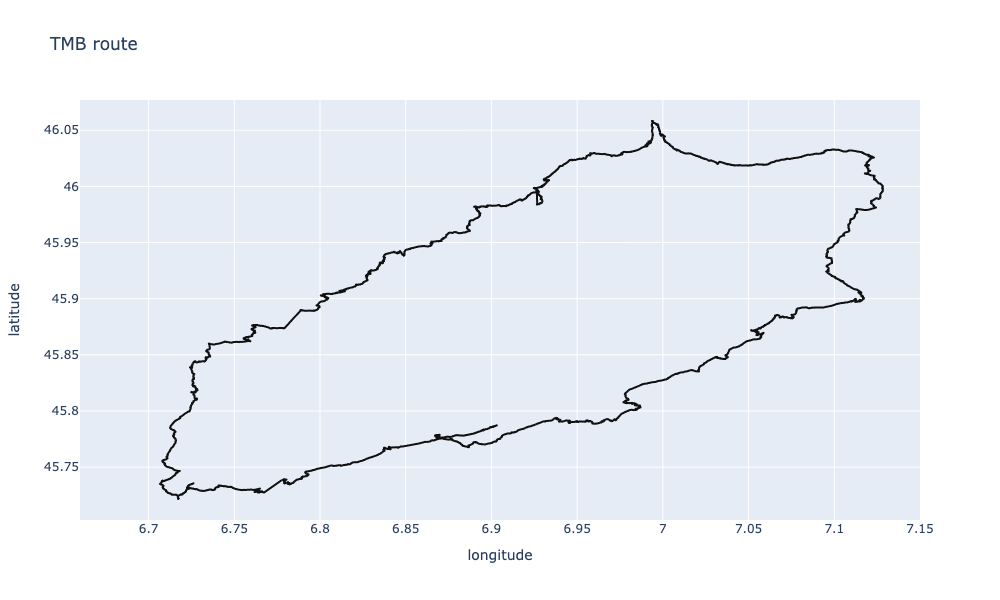

In [43]:
# visualization of the whole TMB route
tmb_route=px.line(df, x='longitude', y='latitude', title='TMB route',  width=1000, height=600)
tmb_route.update_layout(xaxis_title = 'longitude', yaxis_title = 'latitude', xaxis=dict(range=[6.66, 7.15], dtick=0.05), showlegend=False)
tmb_route.update_traces(line=dict(width=2), line_color='#101010')
# tmb_route.show()

# converting the interactive plot into a static image to display in GitHub
tmb_route.write_image("tmb_route.png")
Image("tmb_route.png")

[Back to Contents](#back)

<h2>TMB route per day</h2> <a id='TMB_route_day'></a>

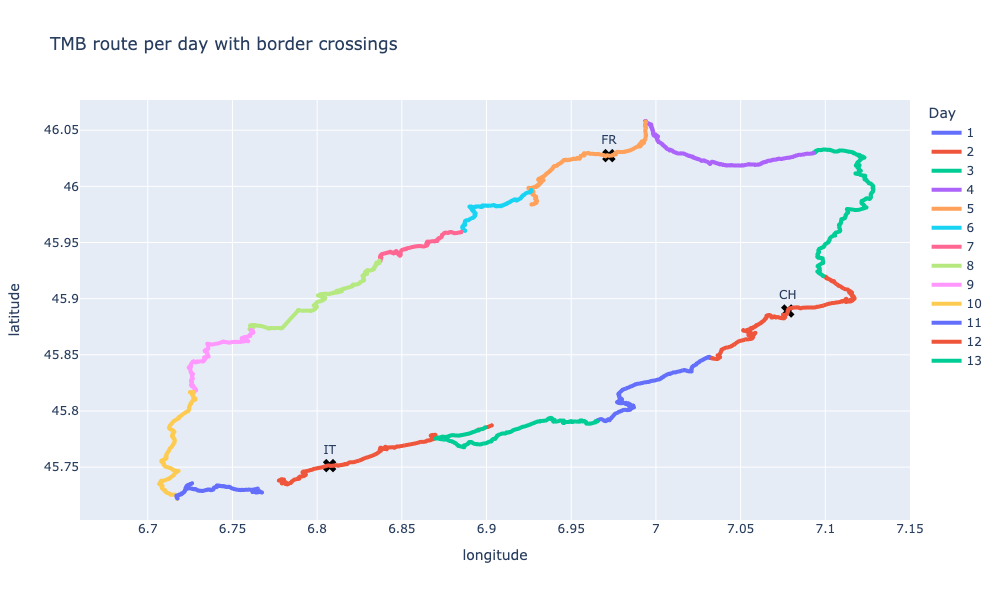

In [46]:
# TMB route split by day with country border markers
# unique color per stage
tmb_stages = px.line(df, x="longitude", y="latitude", color="stage_id", 
                     title='TMB route per day with border crossings',  width=1000, height=600,
                     hover_data={"stage_id": True, "country": True, "longitude": True, "latitude": True},
                     labels={"stage_id": "Day", "country": "Country", "longitude": "Longitude", "latitude": "Latitude"})

tmb_stages.update_layout(xaxis_title = 'longitude', yaxis_title = 'latitude', xaxis=dict(range=[6.66, 7.15], dtick=0.05), showlegend=True)
tmb_stages.update_traces(line=dict(width=4))

# finding indices where country changes to place border markers
borders = df.index[(df["country"] != df["country"].shift()) & (df.index != 0)].tolist()
# shift() moves all values down by 1 row
# df["country"] != df["country"].shift() compares each value in country with the shifted value; returns boolean series (True where country changes)
# df.index != 0 ignores the first row, so it does not count the initial country as a “change”
# df.index[...] selects the indices where the boolean series is True
# .tolist() converts the indices to a list; returns the list of row indices where the country changes

# adding scatter markers at border crossings
for index in borders:
    tmb_stages.add_scatter(
        x=[df.loc[index, "longitude"]],
        y=[df.loc[index, "latitude"]],
        mode="markers+text",
        marker=dict(color="black", size=12, symbol="x"),
        text=[df.loc[index, "country"]],
        textposition="top center",
        showlegend=False
    )

#tmb_stages.show()
tmb_stages.write_image("tmb_stages.png")
Image("tmb_stages.png")

[Back to Contents](#back)

<h2>TMB route elevation</h2> <a id='TMB_route_elevation'></a>

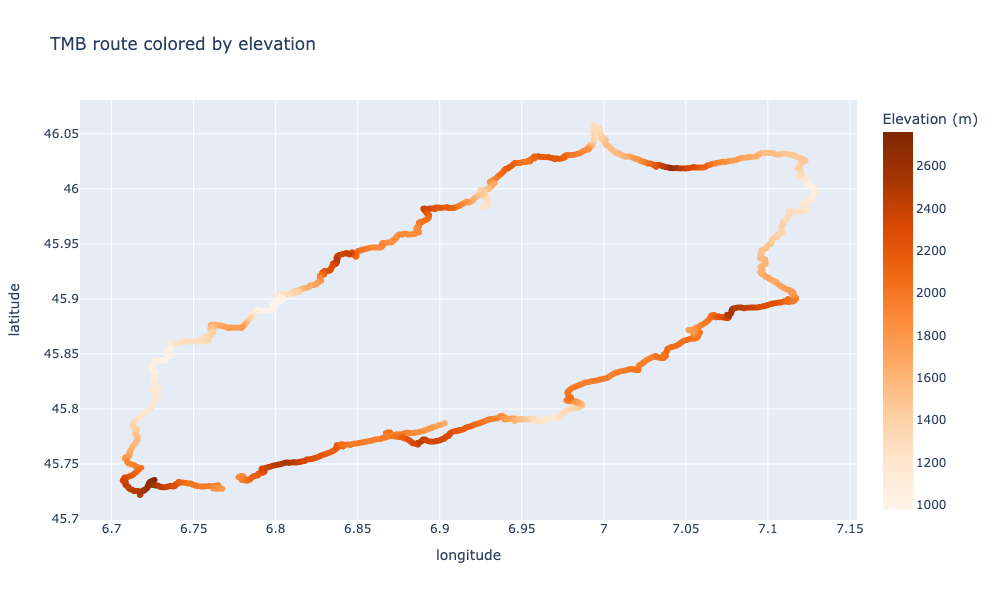

In [49]:
# scatter map of the TMB route colored by elevation
tmb_elevation = px.scatter(df, x="longitude", y="latitude",
    title="TMB route colored by elevation", width=1000, height=600,
    color="elevation (m)", color_continuous_scale="Oranges",
    labels={"longitude": "Longitude", "latitude": "Latitude", "elevation (m)": "Elevation (m)"})

tmb_elevation.update_layout(xaxis_title = 'longitude', yaxis_title = 'latitude')
#tmb_elevation.show()
tmb_elevation.write_image("tmb_elevation.png")
Image("tmb_elevation.png")

[Back to Contents](#back)

<h2>Elevation profile</h2> <a id='TMB_elevation_profile'></a>

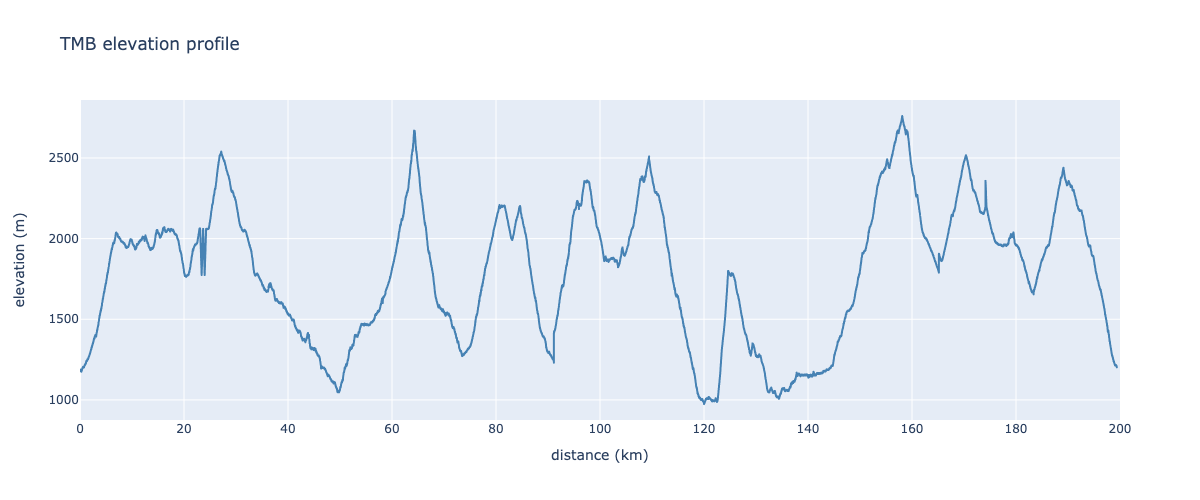

In [52]:
# TMB elevation profile
elev_profile = px.line(df, x=df["cum_dist"]/1000, y='elevation (m)',
                       title='TMB elevation profile',  width=1200, height=500,
                       labels={"x": "Cumulative distance (km)", "elevation (m)": "Elevation (m)"})

elev_profile.update_layout(xaxis_title = 'distance (km)', yaxis_title = 'elevation (m)', xaxis=dict(range=[0, 200], dtick=20), showlegend=False)
elev_profile.update_traces(line_color='steelblue')
#elev_profile.show()
elev_profile.write_image("elev_profile.png")
Image("elev_profile.png")

[Back to Contents](#back)

<h2>Elevation profile per day</h2> <a id='TMB_elevation_profile_day'></a>

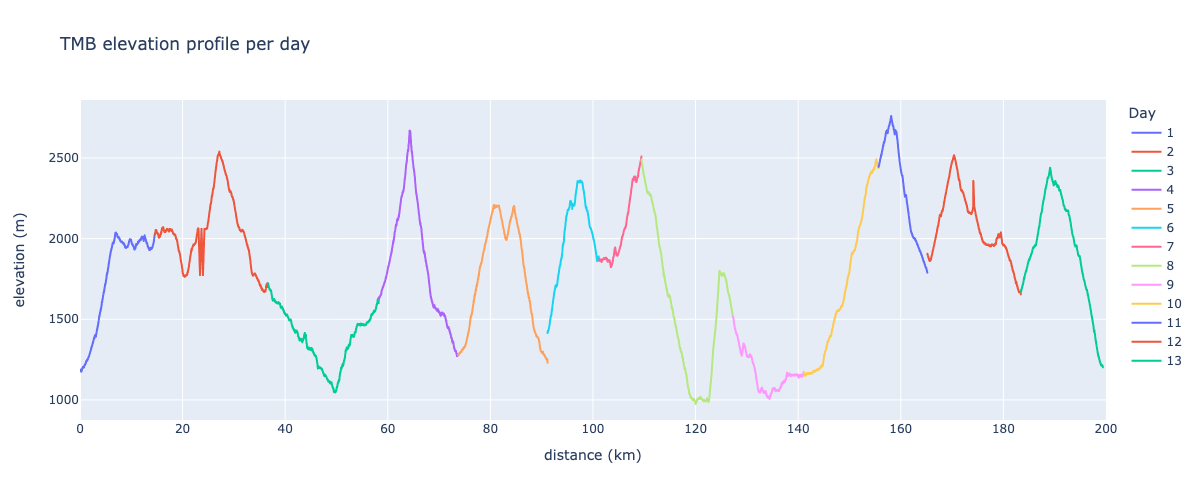

In [55]:
# TMB elevation profile split by day
stage_profile = px.line(df, x=df["cum_dist"]/1000, y="elevation (m)", 
    title="TMB elevation profile per day", width=1200, height=500, 
    color="stage_id", # each stage gets its own color
    labels={"stage_id": "Day", "x": "Cumulative distance (km)", "elevation (m)": "Elevation (m)"})

stage_profile.update_layout(xaxis_title = 'distance (km)', yaxis_title = 'elevation (m)', xaxis=dict(range=[0, 200], dtick=20))
#stage_profile.show()
stage_profile.write_image("stage_profile.png")
Image("stage_profile.png")

[Back to Contents](#back)

<h2>Elevation profile and distance per day</h2> <a id='TMB_elevation_profile_day_distance'></a>

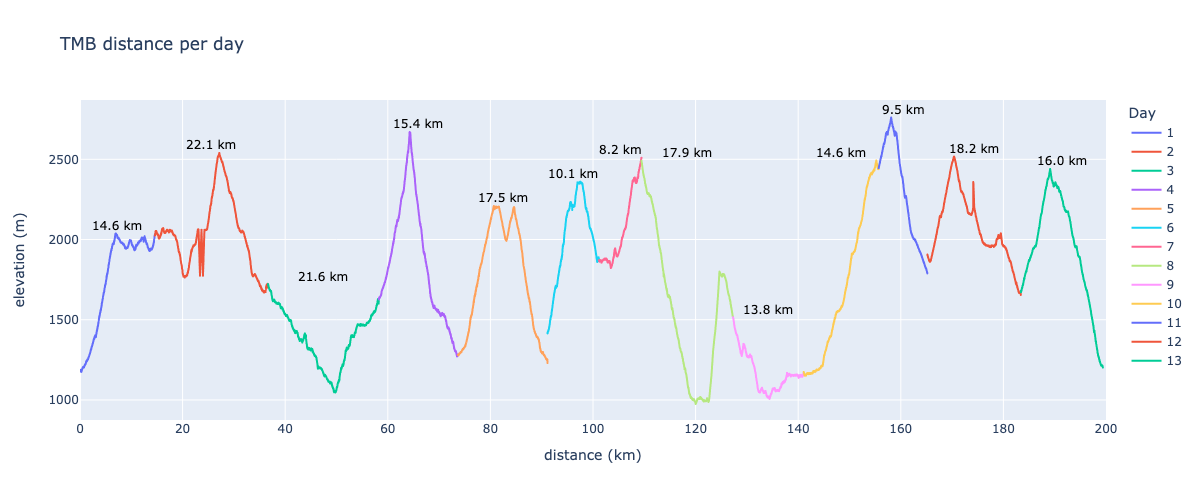

In [58]:
# TMB elevation profile and distance per day
# elevation profile split by day
stage_distance = px.line(df, x=df["cum_dist"]/1000, y="elevation (m)", 
    title="TMB distance per day", width=1200, height=500, 
    color="stage_id", # each stage gets its own color
    labels={"stage_id": "Day", "x": "Cumulative distance (km)", "elevation (m)": "Elevation (m)"})

stage_distance.update_layout(xaxis_title = 'distance (km)', yaxis_title = 'elevation (m)', xaxis=dict(range=[0, 200], dtick=20))

# adding annotations for distance per day
for stage, row in daily_stats.iterrows():
    # selecting data for this stage
    stage_df = df[df["stage_id"] == row["stage_id"]]

    # computing midpoint of the stage on x-axis
    midpoint = ((stage_df["cum_dist"]/1000).min() + (stage_df["cum_dist"]/ 1000).max()) / 2

    # finding max elevation in this stage for placing annotation
    ymax = stage_df["elevation (m)"].max()

    # adding annotation
    stage_distance.add_annotation(
        x=midpoint,
        y=ymax + 50, # 50 m above the max for clarity
        text=f"{row['distance_m']/1000:.1f} km",
        showarrow=False,
        font=dict(size=12, color="black"),
        align="center"
    )

#stage_distance.show()
stage_distance.write_image("stage_distance.png")
Image("stage_distance.png")

[Back to Contents](#back)

<h2>Lodging and distance per day</h2> <a id='TMB_lodging_distance'></a>

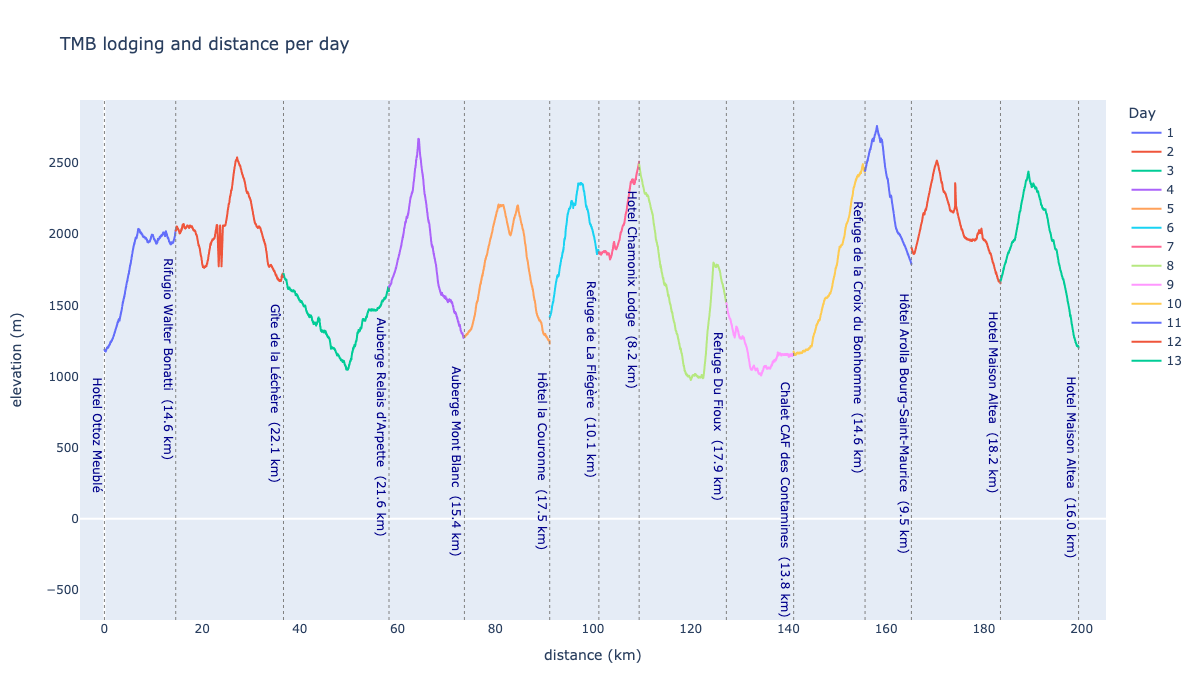

In [61]:
# TMB lodging and distance per day
# a list of accommodations
refuges = [
    "Hotel Ottoz Meublé",
    "Rifugio Walter Bonatti",
    "Gîte de la Léchère",
    "Auberge Relais d'Arpette",
    "Auberge Mont Blanc",
    "Hôtel la Couronne",
    "Refuge de La Flégère",
    "Hotel Chamonix Lodge",
    "Refuge Du Fioux",
    "Chalet CAF des Contamines",
    "Refuge de la Croix du Bonhomme",
    "Hôtel Arolla Bourg-Saint-Maurice",
    "Hotel Maison Altea",
    "Hotel Maison Altea"
]

# elevation profile split by day
lodging_distance = px.line(df, x=df["cum_dist"]/1000, y="elevation (m)",
    title="TMB lodging and distance per day",  width=1200, height=700,
    color="stage_id", # each stage gets its own color
    labels={"stage_id": "Day", "x": "Cumulative distance (km)", "elevation (m)": "Elevation (m)"})

lodging_distance.update_layout(xaxis_title = 'distance (km)', yaxis_title = 'elevation (m)', 
                               xaxis=dict(range=[-5, 205], dtick=20, showgrid=False),
                               yaxis=dict(showgrid=False))

# vertical line at start of day 1
lodging_distance.add_vline(x=df["cum_dist"].iloc[0]/1000, line=dict(color="gray", width=1, dash="dot"), layer="above")

# first lodging at start of day 1
start_alt = df["elevation (m)"].iloc[0]
lodging_distance.add_annotation(
    x=df["cum_dist"].iloc[0]/1000-1.5,
    y=start_alt - 180,
    text=refuges[0],
    showarrow=False,
    font=dict(size=12, color="darkblue"),
    textangle=90,
    xanchor="center",
    yanchor="top") # if the text should start exactly at the altitude and go below it

# adding annotations for distance and lodging per day
for stage, row in daily_stats.iterrows():
    # selecting data for this stage
    stage_df = df[df["stage_id"] == row["stage_id"]]
    # finding end of each stage in cumulative distance
    end_km = (stage_df["cum_dist"]/1000).max()
    # computing midpoint of the stage on x-axis
    midpoint = ((stage_df["cum_dist"]/1000).min() + (stage_df["cum_dist"]/ 1000).max()) / 2
    # finding max elevation in this stage for placing annotation
    ymax = stage_df["elevation (m)"].max()

    # adding vertical lines at end of each stage to divide route per day
    lodging_distance.add_vline(x=end_km, line=dict(color="gray", width=1, dash="dot"), layer="above")

    # lodging + distance annotation at end-of-day altitude
    end_alt = stage_df["elevation (m)"].iloc[-1]
    offset = 190
    position_y = end_alt - offset
    
    # adding refuge names as vertical text along the lines
    lodging_distance.add_annotation(
        x=end_km-1.5, 
        y=position_y,
        text=refuges[stage + 1] + f"  ({row['distance_m']/1000:.1f} km)",  # [stage + 1] to avoid repeating the first one
        showarrow=False,
        font=dict(size=12, color="darkblue"),
        textangle=90,  # vertical text
        xanchor="center",
        yanchor="top")

#lodging_distance.show()
lodging_distance.write_image("lodging_distance.png")
Image("lodging_distance.png")

[Back to Contents](#back)

<h2>Total distance per country</h2> <a id='distance_country'></a>

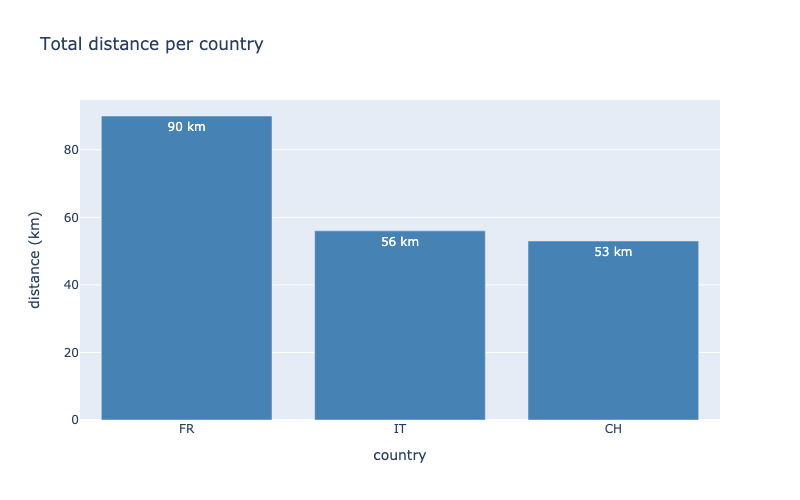

In [64]:
# distance per country
country_totals = df.groupby("country")["distance (m)"].sum().reset_index().sort_values(by="distance (m)", ascending=False) 

country_dist=px.bar(country_totals, x='country', y=(country_totals["distance (m)"]/1000).round(0).astype(int), 
                    title='Total distance per country', width=800, height=500,
                    labels={"country": "Country", "y": "Distance (km)"}, 
                    text=(country_totals["distance (m)"] / 1000).round(0).astype(int).astype(str) + " km") # display text on bars

country_dist.update_layout(xaxis_title = 'country', yaxis_title = 'distance (km)', showlegend=False, xaxis = dict(tickmode = 'linear', dtick = 1))
country_dist.update_traces(marker_color='steelblue')
#country_dist.show()
country_dist.write_image("country_dist.png")
Image("country_dist.png")

[Back to Contents](#back)

<h2>Distance per day: flat, uphill, downhill</h2> <a id='distance_profile'></a>

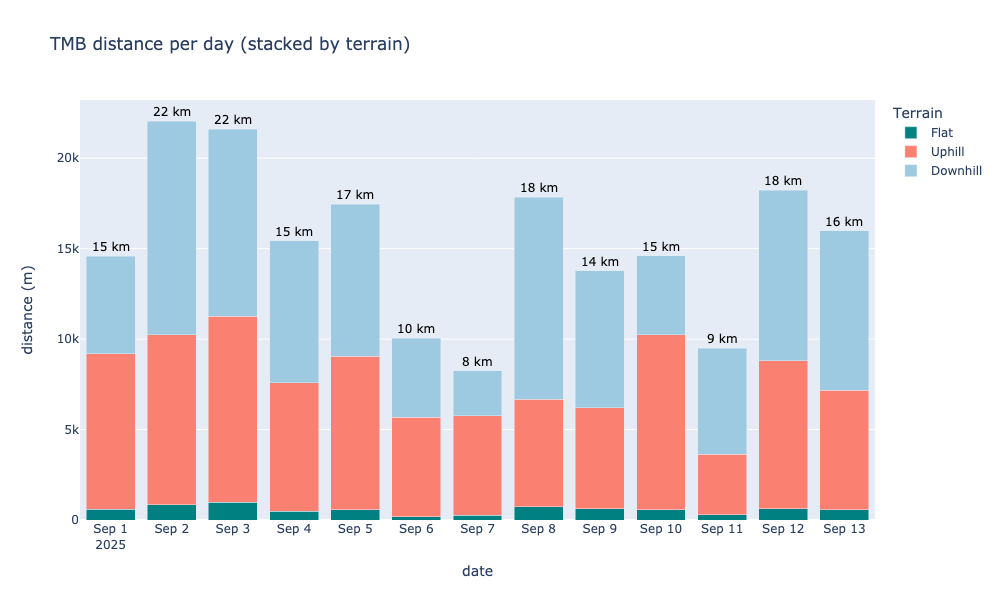

In [67]:
# distance per day
daily_distance=px.bar(daily_stats, x='datetime', y=["flat_m", "ascent_m", "descent_m"],
                    title='TMB distance per day (stacked by terrain)', width=1000, height=600,
                    labels={"value": "Distance (m)", "datetime": "Date", "variable": "Terrain"},
                    color_discrete_map={"flat_m": "teal", "ascent_m": "salmon", "descent_m": "rgb(158,202,225)"})

new_legend = {"flat_m": "Flat", "ascent_m": "Uphill", "descent_m": "Downhill"}
daily_distance.for_each_trace(lambda x: x.update(name=new_legend[x.name]))
daily_distance.update_layout(barmode="stack", xaxis_title = 'date', yaxis_title = 'distance (m)', xaxis=dict(tickmode = 'linear'),  showlegend=True)
    
#adding total distance labels on top of each bar
for _, row in daily_stats.iterrows():
    total_m = row["distance_m"]
    daily_distance.add_annotation(
        x=row["datetime"],
        y=row["distance_m"],
        text=f"{total_m/1000:.0f} km",
        showarrow=False,
        font=dict(size=12, color="black"),
        yanchor="bottom"
    )

#daily_distance.show()
daily_distance.write_image("daily_distance.png")
Image("daily_distance.png")

[Back to Contents](#back)

<h2>Hiking time per day</h2> <a id='duration_day'></a>

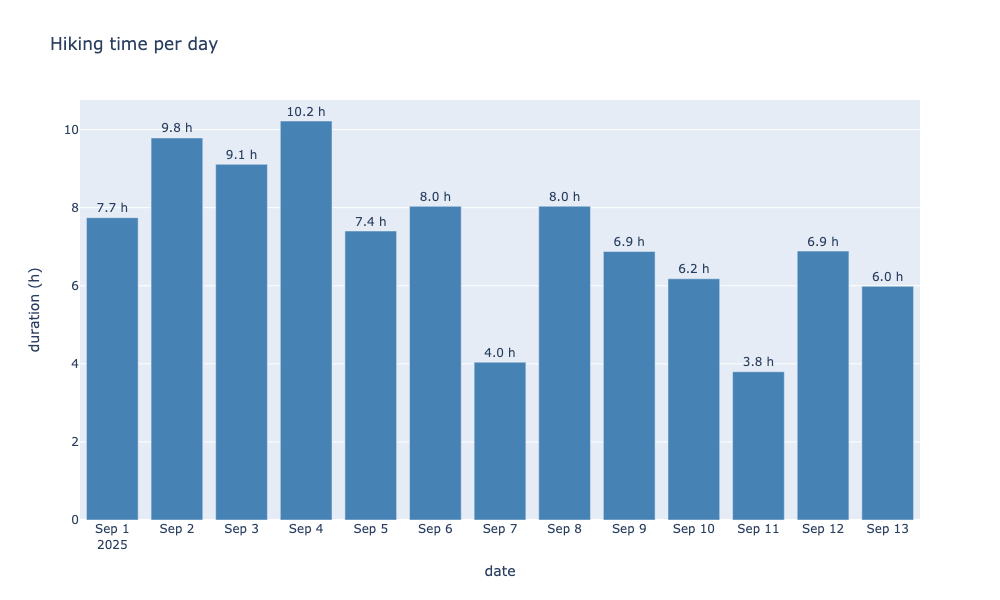

In [70]:
# walking hours per stage
daily_duration = px.bar(daily_stats, x='datetime', y='duration_h', 
    title='Hiking time per day', width=1000, height=600,
    labels={'datetime': 'Date', 'duration_h': 'Duration (hours)'},
    text='duration_h')  # display values on top of bars

daily_duration.update_traces(texttemplate='%{text:.1f} h', textposition='outside', marker_color='steelblue') # style of values on top of bars
daily_duration.update_layout(xaxis_title = 'date', yaxis_title = 'duration (h)', xaxis=dict(tickmode = 'linear'), showlegend=False)
#daily_duration.show()
daily_duration.write_image("daily_duration.png")
Image("daily_duration.png")

[Back to Contents](#back)

<h2>Average speed per day</h2> <a id='speed_day'></a>

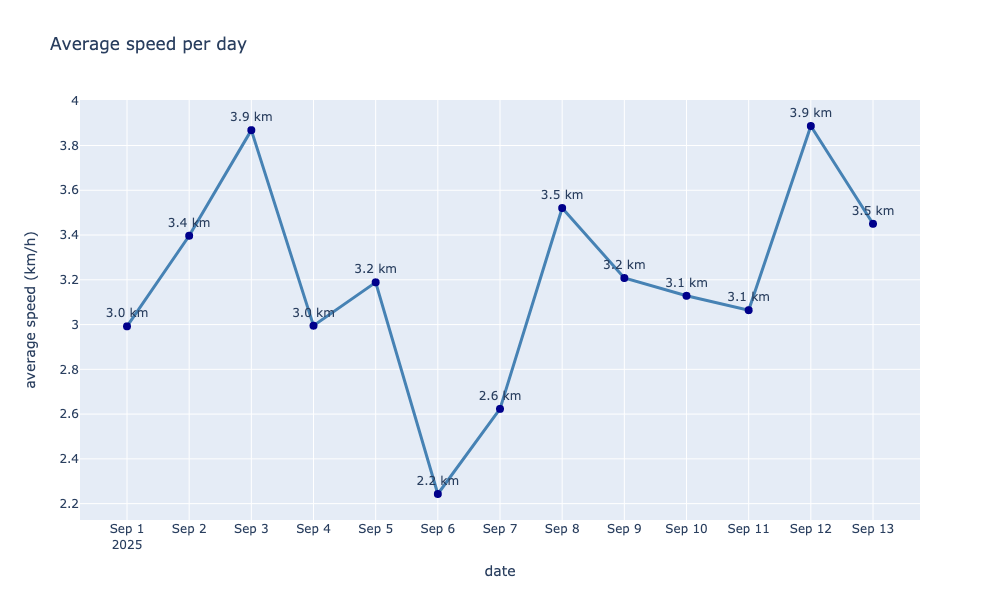

In [73]:
# average speed per day
daily_speed = px.line(daily_stats, x='datetime', y='avg_speed_kmh',
    title='Average speed per day', width=1000, height=600,
    labels={'datetime': 'Date', 'avg_speed_kmh': 'Average speed (km/h)'},
    text=(daily_stats["avg_speed_kmh"]).round(1).astype(str) + " km",
    markers=True)  # adds scatter points

daily_speed.update_traces(textposition='top center', line=dict(width=3, color='steelblue'), marker=dict(size=8, color='darkblue'))
daily_speed.update_layout(xaxis_title = 'date', yaxis_title = 'average speed (km/h)', xaxis=dict(tickmode = 'linear'))
#daily_speed.show()
daily_speed.write_image("daily_speed.png")
Image("daily_speed.png")

[Back to Contents](#back)